# Order in the Court! :  Unsupervised Learning on Supreme Court Tax Cases in the Philippines for a Case Retrieval System
Prepared by: Manansala, Dorosan, Edeza, Gonzales, Licong, Marquez

<img src="https://i.ibb.co/RS9H9x7/supreme-court-building.jpg" alt="supreme-court-building" border="0" width=700>

## Executive Summary 

In the practice of law, legal research is one of the most painstakingly long process that takes most of the time of the law practitioners. To properly formulate and strategize their existing cases, they must be able to pinpoint the most relevant case and build their strategies from the weaknesses of the previous cases. However, there is currently no case retrieval system that can provide this need of the Filipino law practitioners. According to law practitioners, the current legal research in the Philippines is usually dependent on more general algorithms of search engines such as Google. While this somewhat aides research, a practitioner may still need to filter through search results which are primarily based on search engine optimization metrics other than actual relevance of results to the practice. Almost all the time, this does not lead to the relevant cases which can be frustrating for law practitioners given the number of documents they need to read.

With this in mind, we developed a case retrieval system specifically for tax case decisions of the Philippine Supreme Court. Unsupervised learning was also implemented to cluster the tax cases based on their term-document similarities. In the end, we were successful in clustering the tax-related Supreme Court cases into four clusters: **VAT-related**, **Criminal Tax Evasion**, **Corporate Tax**, and **Tax Disputes** clusters. These cluster results were used as ground truth to evaluate the performance of the case retrieval system that we built, resulting to an AUC-ROC score of 0.745.

Our initial success provides throught-provoking insights into further optimizing the stopword generator we initially used to process our bag-of-words data. Our methods of filtering out noise due to stopwords are still heavily dependent on a threshold based algorithm in determining corpus-specific stopwords. We recommend further research in this direction as well as extensive external validation by practitioners of clustering and case retrieval system results.









## I. Introduction

Though not one of its most well-known applications, the use of data science in the field of law has yielded fruitful research. A 2018 article by Chibueze makes use of data science, natural language processing, in particular, to extract key topics and words within a text.<a href="https://towardsdatascience.com/nlp-for-topic-modeling-summarization-of-legal-documents-8c89393b1534">(Chibueze 2019)</a>. Chibueze posited that such an algorithm would be able to help both practitioners and laypeople parse through and better understand the makeup of legal document archives. Indeed, many researchers have tried their hand at using natural language processing in the analysis of legal documents.

In a 2019 study by Medveda, Vols, and Wieling, they were able to use machine learning to predict the outcome of a case using only textual analysis. The resulting support vector machine model had an accuracy of 75% <a href="https://link.springer.com/article/10.1007/s10506-019-09255-y">(Medveda, Vols, and Wieling  2019)</a>.

The law profession lends itself quite well to natural language processing and big data analysis. The field has a large corpus of cases, and the details of each case are meticulously detailed. The language used also tends to follow a single formal tone, which limits the effect of an individual writer's style. This makes cases much more comparable to each other despite tackling radically different topics.

A 2018 study in the Philippines also used the technique to be able to predict Supreme Court Decisions <a href="https://ieeexplore.ieee.org/document/8377844">(Virtucio et al 2018)</a>. The group was able to tune their random forest model to yield an accuracy of 59%. However, it is notable that the group's dataset consisted of much more diverse cases than the 2019 research. This much broader dataset may have contributed to the weaker performance of the group's model. The group notes that they wish to pursue this topic and eventually apply their research to the lower courts where case backlogs have caused problems.

The study of our paper is to apply unsupervised learning, specifically clustering analysis and information retrieval techniques, to Supreme Court (SC) cases in the Philippines. The data was taken from the  <a href="http://elibrary.judiciary.gov.ph/">e-Library of the Supreme Court</a>. The analysis and exploration will target tax cases. The data used is a bag-of-words based on the body of the cases filed as tax-related Supreme Court Decisions from 2001 to 2020.


### Problem Statement and Rationale

After discussions with individuals in the field, we were informed that a worthwhile topic to pursue would be tax cases. The reason for this is that tax cases tend to be resolved faster because it has a direct effect on the revenues of the government. Also, tax cases usually involve sums of money that far exceed criminal and civil cases.

Our group analyzed different tax cases that have been raised to the Philippines' Supreme Court from 2001 to 2020 to give a clearer picture of how these cases can be clustered. Additionally, we built a case retrieval system (tax case search engine) based on documents' terms similarity to facilitate research of tax-related SC cases.

In doing so, we answered the following questions:
1.	How can tax-related cases from 2001 to 2020 be clustered?
2.	How can we remove the corpus-specific commonly occurring words (stopwords) in tax-related SC cases?
3.	What factors impact the effectiveness of our case retrieval system?

Answering the above questions crucial to  (i) *removing noise caused by stopwords*, (ii) *decreasing model complexity*, (iii) *optimizing our KMeans clustering*, and (iv) *evaluating the performance of our case retrieval system*.

## II. Methodology

<img src="https://i.ibb.co/X3PHHJH/court-methodology.png" alt="court-methodology" border="0">
<center>Figure 1. Cluster Analysis Workflow</center>

#### A. Data Acquisition and Description

 We scraped all of the Philippine Supreme Court Decisions and Rulings from the [Supreme Court e-Library](http://elibrary.judiciary.gov.ph/). We did this by initially scraping the URLs of cases dated January 2000 to February 2020 from the e-Library landing page. We then used these URLs to scrape the `text` data of each case along with the `case number`, `case title`, `date released`, `presiding SC`. We then saved all $24,404$ cases scraped into an SQlite database. After the data cleaning and processing described in the next section, we obtained a corpus of $468$ tax-related cases.
 
For reuseability and maintenance purposes, we created `.py` file to serve as utility modules for this project. The utility modules should be inside a folder name `utils`, which is in the same directory of this supplementary notebook.

Utility modules:
1. `case_retriever` - this module's primary purpose is for the clustering and information retrieval part of the project.
2. `case_scraper` - this module is used in scraping the Supreme Court cases.
3. `vectorizer` - this module is for the vectorization of the cases.

In [1]:
import re
import time
import requests
import bs4
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

# import utility modules
from utils import case_retriever, case_scraper, vectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2021/jgonzales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/msds2021/jgonzales/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [35]:
from IPython.display import Image 
# This is only for presentation
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### B. Data Preprocessing

In [2]:
# Reading the temporary databases for data preparation and processing

db_path = '/mnt/processed/private/msds2021/lt10/'
db1 = 'supreme_court.db'
db2 = 'supreme_court_part2.db'
table1 = 'supreme_court'
table2 = 'supreme_court_cases'

conn = sqlite3.connect(db_path + db1)
df_info1 = (pd.read_sql(f"""SELECT * FROM {table1}""", conn)
            .drop(['index'], axis=1))
df_cases1 = (pd.read_sql(f"""SELECT * FROM {table2}""", conn)
             .drop(['index'], axis=1))

conn2 = sqlite3.connect(db_path + db2)
df_info2 = (pd.read_sql(f"""SELECT * FROM {table1}_2""", conn2)
            .drop(['index'], axis=1))
df_cases2 = (pd.read_sql(f"""SELECT * FROM {table2}2""", conn2)
             .drop(['index'], axis=1))

***Text preparation***
    
From the gathered data, we merged the cases from the two temporary databases into one dataframe, which will then be used for processing. As a start, we converted all text data in the `Title`, which is the case title and `Text` which is the case body into lower case.

In [3]:
df_merged1 = pd.merge(df_info1, df_cases1, how="inner", on="Link")
df_merged2 = pd.merge(df_info2, df_cases2, how="inner", on="Link")
df_merged = pd.concat([df_merged2, df_merged1]).drop_duplicates()
# df_merged.to_sql('supremo', 'sqlite:////mnt/processed/private/'
#               'msds2021/lt10/supremo.db', if_exists='replace', index=False)

In [4]:
df_merged['Title'] = df_merged['Title'].str.lower()
df_merged['Text'] = df_merged['Text'].str.lower()
df_merged['Text'] = df_merged['Text'].str.replace("\n", " \n ")

***Classification of cases and filtering of Tax cases***

To narrow down our corpus to only cover tax-related cases, we classified the Supreme Court Case Decisions into three (3) main groups, namely: Criminal Cases, Civil Cases, and Tax Cases. Using regex, we used the following criteria to filter the cases into the three classifications. Note that all cases not classified as Tax nor Criminal cases are put under Civil Cases, acting as a catch-all group. Presented below are terms that guided this classification.


| Type of Case | Case Title | Case Body| 
|:-|:-|:-|
| Criminal Cases | contains "People of the Philippines" | n/a |
| Tax Cases | contains "Commissioner of Internal Revenue" | n/a |
| | contains "Court of Tax Appeals" | n/a |
| | contains "People of the Philippines" | contains "Commissioner of Internal Revenue"| 
| | contains "People of the Philippines" | contains "Court of Tax Appeals"| 
| Civil Cases | n/a | n/a | 

In [5]:
tax_case_identifier = 'commissioner of internal revenue|court of tax appeals'
private_filer = 'people of the philippines'

new_df = df_merged[df_merged['Title'].str.contains(tax_case_identifier)]
new_df2 = df_merged[df_merged['Title'].str.contains(private_filer) 
                    & df_merged['Text'].str.contains(tax_case_identifier)]
final_df = pd.concat([new_df, new_df2])

# uncomment the following line if needed
# final_df.to_sql('tax_cases', 'sqlite:////mnt/processed/private/'
#              'msds2021/lt10/tax_cases.db', if_exists='replace', index=False)

***Determining Case Outcomes***

We removed the footnotes of the case body since these include pieces of information that are irrelevant to our stated scope, such as references to other cases. We also removed all reference markers to the footnotes (e.g. [1], [a], in-text citations). We also extracted from the case decision information from the concluding statement for each case and saved in the database table as the column `Decision`. We did this through the use of *regular expressions* (regex) aided by `Python`'s `re` library, specifically by identifying patterns in a decision's opening and closing statements. 
    
To determine whether the government files the case decision, we created a new column `Filed by Government`. This was done by splitting the title by the "vs." and retrieving the text preceding the said text. If the words "People of the Philippines", "Commissioner of Internal Revenue", or "Court of Tax Appeals" are on the text preceding "vs.", then we considered it filed by the government and was labeled with `1`. Otherwise, it was filed by a private entity and thus labeled `0`.  
    
We also created another column, `Win for Petitioner`, from the contents of the extracted `Decision` text. Using regex, a list of catchwords were created to determine the case outcome - some of these catchwords are "*the petition is hereby granted*", "*we deny the petition*", "*lower court decision is affirmed*", "*decision of the court of appeals is hereby reversed*", "*petition for review is dismissed*", "*decision is reversed and set aside*", and etc. A label of `0` is placed if the catchword include the words "*denied*", "*dismissed*", "*affirmed*", etc. which signifies that the lower court decision was upheld and the petitioner lost the case. Conversely, a label of `1` is placed if the catchword includes the words "reversed", "granted", "set aside", etc. which signifies that the lower court decision was reversed and the petitioner has won the case. 
    
In addition, we included a `Modified` column to determine if there are settlements and partial granting of the case. Using regex, the words "*modification*", "*partly*", "*partially*", etc. were filtered from the `Decision` text. Cases containing said catchwords were labeled `1` in this `Modified` column.
    
From the `Win for Petitioner` column, we also simplified the results of SC rulings as either a `Win for Government` (`1`), a loss (`0`), or a settlement (`Modified`). The logic is shown in the table below. As such, the government wins the case decision on two occurrences: (1) if the government filed and petitioned the case, and the petitioner won the case (2) if the government did not file the petition for the case, and the petitioner lost the case. Lastly, a third classification was created using the flags from the column `Modified`. If the case is modified, the `Win for Government` column will yield a "Modified" value instead of True or False since the settlements and conditions in the case decisions cannot be expressed in the boolean form.  
    
| Filed by Government | Win for Petitioner | Modified | Win for Government |
|:--:|:--:|:--:|:--:|
| True | True | False | True |
| True | False | False | False | 
| False | True | False | False |
| False | False | False | True |
| -any- | -any- | True | Modified |

In [6]:
# Extracting the decision section in the case body
d_section = '))in?+ view?+ whereof|accordingly|wherefore|for?+ the?+ foregoing?+ reasons:?(?*]S\\s\\[so?+ ordered.('
d_section2 = '))in?+ view?+ whereof|accordingly|wherefore|for?+ the?+ foregoing?+ reasons:?(?*]S\\s\\[concur('

final_df['Decision'] = (final_df.Text.str[::-1].str.
                        extract(fr'{d_section[::-1]}'))
final_df['Decision1'] = (final_df.Text.str[::-1].str.
                         extract(fr'{d_section2[::-1]}'))
final_df['Decision'] = final_df.Decision.combine_first(final_df['Decision1'])
final_df['Decision'] = final_df.Decision.str[::-1]
final_df = final_df.drop(['Decision1'], axis=1)

# Extracting sections needed to be removed
for_removal = '(^[\s\S]*?)rucnoc'
final_df['removals'] = final_df.Text.str[::-1].str.extract(fr'{for_removal}')
final_df['removals'] = final_df.removals.str[::-1]

final_df["Text"] = (final_df.apply(lambda x: x['Text']
                                  .replace(str(x['Decision']), ""), axis=1))
final_df["Text"] = (final_df.apply(lambda x: x['Text']
                                  .replace(str(x['removals']), ""), axis=1))
final_df = final_df.drop(['removals'], axis=1)

In [7]:
# Filed by Government feature
filer = f'{private_filer}|{tax_case_identifier}'
final_df['Filed by Government'] = (final_df['Title']
                                        .apply(lambda x: x.split('vs')[0]))

final_df['Filed by Government'] = \
    final_df['Filed by Government'].str.contains(filer)

In [8]:
decision_affirmed = ['denied', 'affirmed', 'dismissed', 'deny', 'dismiss', 
                     'denies', 'ordered', 'declared', 'lack of merit', 
                     'affirms']
decision_reversed = ['reversed', 'granted', 'grant', 'grants', 'remanded', 
                     'reversed and set aside', 'set', 'reinstated', 'remand', 
                     'reverses', 'reinstate', 'nullified', 'cancelled']
cost_againt_loss = ['petitioner', 'petitioners']
cost_againt_win = ['respondent', 'respondents', 'accused']
modified = ['modification', 'modify', 'partly', 'partially', 'in part']

decision_identifiers = [
    r"(modification|modify)",
    r"(?<=petition is hereby )(\w+)",
    r"(?<=petition for review is hereby )(\w+)",
    r"(?<=court of appeals is hereby )(\w+)",
    r"(?<=we )(\w+)(?= the petition)",
    r"(?<=court )(\w+)(?= the petition)",
    r"(?<=we partly)(\w+)(?= the petition)",
    r"(?<=court partly)(\w+)(?= the petition)",
    r"(?<=petition is hereby partly )(\w+)",
    r"(?<=petition is hereby partially )(\w+)",
    r"(?<=petition is partly )(\w+)",
    r"(?<=petition is partially )(\w+)",
    r"(?<=petition is in part )(\w+)",
    r"(?<=petition is )(\w+)",
    r"(?<=petition for review is )(\w+)",
    r"(?<=petition for review on certiorari is hereby )(\w+)",
    r"(?<=petition for review on certiorari is )(\w+)",
    r"(?<=court of appeals is )(\w+)",
    r"(?<=costs against) (\w+)",
    r"orders the (petitioner) to pay the costs",
    r"(reversed and set aside)",
    r"(denied) for lack of merit",
    r"(lack of merit)",
    r"(?<=we partly )(\w+)(?= the)",
    r"(?<=court partly )(\w+)(?= the)",
    r"(?<=we )(\w+)(?= with finality)",
    r"(?<=are )(\w+)(?= the special allowance)",
    r"(?<=we )(\w+)(?= the)",
    r"(?<=court )(\w+)(?= the)",
    r"(?<=are hereby partially )(\w+)",
    r"(?<=is hereby partially )(\w+)",
    r"(?<=are hereby )(\w+)",
    r"(?<=is hereby )(\w+)",
    r"(?<=is )(\w+)",
    r"(?<=are )(\w+)"
]

In [9]:
for idx, identifier in enumerate(decision_identifiers):
    res_col = f'result_{idx}'
    final_df[res_col] = final_df.Decision.str.extract(identifier)

filer_win = 'Win for Petitioner'
final_df[filer_win] = final_df['result_1'].combine_first(final_df['result_2'])
for x in range(2, 35):
    final_df[filer_win] = \
        final_df[filer_win].combine_first(final_df[f'result_{x}'])

In [10]:
final_df[filer_win] = (final_df[filer_win].transform(
                       lambda x: False if x in decision_affirmed else x))
final_df[filer_win] = (final_df[filer_win].transform(
                       lambda x: True if x in decision_reversed else x))
final_df[filer_win] = (final_df[filer_win].transform(
                       lambda x: True if x in cost_againt_win else x))
final_df[filer_win] = (final_df[filer_win].transform(
                       lambda x: False if x in cost_againt_loss else x))
final_df['Modified'] = (final_df['result_0'].transform(
                        lambda x: True if x in modified else False))

final_df = final_df.drop([f'result_{x}' for x in range(0, 35)], axis=1)

mod_filer_win = 'Modified Win for Petitioner'
govt_win = 'Win for Government'
govt_filer = 'Filed by Government'
final_df[mod_filer_win] = final_df.apply(
    lambda x: False if bool(x['Modified']) else x[filer_win], axis=1)
final_df[govt_win] = ~ (final_df[govt_filer] ^ final_df[mod_filer_win])
final_df[govt_win] = final_df.apply(
    lambda x: 'Modified' if bool(x['Modified']) else x[govt_win], axis=1)

#### C. Building of stopword generator

Since our data involved cases which are all written using the English language, the `English` stopwords available in the `sklearn` library provides a good starting point in eliminating the noise from our corpus. However, the corpus we are worked on contains more specialized but commonly occurring words such as `tax` and `en banc`. To address these words, we built a corpus-specific generator patterned from the baseline method discussed in the study of <a href="http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf">Lo *et al* (2020)</a>. 

Specifically, we first calculated for the inverse document frequency of terms in the corpus according to the formula:

 \begin{equation}
idf_{x} = \log\frac{n_D}{D_x}
 \end{equation}

where $n_D$ is the number of documents in the corpus and $D_x$ is the number of documents containing the term $x$.

In this method, frequently occurring words across all documents are weighted less. We then determined an idf threshold for the terms' by observing where a sudden increase in idf score occurs.  Those with idf scores below the determined threshold are qualified as stopwords and were thus added to the stopword collection.

In [11]:
# jojie location
db_path = '/mnt/processed/private/msds2021/lt10/'
supremo = 'supremo.db'
taxes = 'tax_cases.db'

In [12]:
t_conn = sqlite3.connect(db_path + taxes)
tax_cases = pd.read_sql("""SELECT * FROM tax_cases""", con=t_conn)

In [13]:
tax_docs = tax_cases.Text.values.tolist()
vocab = list(set([i for sub_doc in tax_docs 
                  for i in sub_doc.strip().split()]))

In [14]:
tax_stopwords = vectorizer.generate_stopwords(vocab, tax_docs)
stopwords = tax_stopwords[tax_stopwords.idf <= 1.082177].word.tolist()
stopwords += ['roque', 'san', 'corona', 'powers', 'en', 'banc', 
              'ra', 'da', 'her', 'ca', 'cir', 'rr']
# set stopwords for util module
_ = vectorizer.get_or_set_stopwords(stopwords)

#### D. Tokenizer with Lemmatization

Before representing documents as vectors, it is necessary to first represent document terms as tokens. To do so, we used `nltk.tokenize`'s `word_tokenize()` function to break down documents into its terms. However, this method does not consider words that have common roots (i.e., `generalize`, `generalization`, and `general` are all identified as unique tokens despite being redundant in root meaning). We used the `WordNetLemmatizer()` class from `nltk` to transform words into their roots to obtain root-words as tokens, thereby, removing the redundancy.

*Please see `remove_noise` function in `utils/vectorizer.py` for the code*

#### E. Vectorization
The documents were then represented as vectors by using `sklearn`'s `TfidfVectorizer()` class. The vectorizer object was first initialized with the following key parameters:
* `tokenizer`=`remove_noise` : a callable function built using the methods discussed above
* `min_df`=`0.15` : set to remove rarely occurring words but are otherwise provide irrelevant information (e.g., company/private persons' names which are specific to cases)
* `max_df`=`0.60` : set to address words which were not covered by the stopwords algorithm employed during tokenization but provide minimal insight to the cluster interpretation
* `use_idf`=`True` : enables idf weighting of tokens

The `.fit_transform()` method of the vectorizer object was then used on the corpus to obtain a vectorized sparse matrix. 

In [15]:
# get vectorizer and dataframe of vectorized cases
vect, vect_df = vectorizer.get_vectorizer(tax_cases.Text)

#### F. Clustering
After vectorization, the bag-of-words data were then clustered using `sklearn`'s `KMeans()` clustering. The following are the specific steps to the clustering that we performed:
1. Transform the bag-of-words sparse matrix into its singular value decomposition using `TruncatedSVD()`
2. Qualitative visual inspection of different choices of $k$ (number of clusters) for the `KMeans()` algorithm.
3. Internal validation of optimal $k$ using four metrics: Silhouette coefficient, Calinski-Harabasz score, Gap Statistic, and Sum of Squared Error. 
4. Qualitative validation and inspection of the most frequent terms for each cluster

These four steps guided our analysis to choose the number of clusters relevant (i) to *build an information retrieval system for tax cases* and (ii) to *get a clear picture of the clustering of tax cases in the Philippines.* 

In [16]:
cluster_range = case_retriever.cluster_range(vect_df.to_numpy(), 
                                             KMeans(random_state=1337), 2, 11)

100%|██████████| 10/10 [05:37<00:00, 33.72s/it]


#### G. Case Retrieval System
Finally, we constructed a case retrieval system by using the `closest_euc()` function in the `case_retriever.py` module. This algorithm works by ranking the documents according to each document's similarity to a query. 

We did this by first transforming a query into a vector. The `closest_euc()` algorithm then calculates the pairwise Euclidean distance of the query with each document in the corpus. The documents are then given ranks according to the distance calculated, arranged from smallest (closest) to largest (farthest) distance value. We used this distance as our measure of similarity.

## III. Results and Discussion

In this section, we discuss the justification of our choice of $k=4$ which, is the number of meaningful clusters from the data. Specifically, results from internal validation, most frequent terms/words per cluster, and cluster plots are discussed. 

#### A. Internal Validation

Our initial approach in finding the optimal number of clusters is to validate results for $k=2$ to $k=11$ using the following metrics:

1. Calinzki-Harabasz Score
2. Sum of Squared Error (SSE)
3. Gap Statistic
4. Silhouette Coefficient Score

These are the go-to metrics whenever there is no ground truth to validate clustering results with, as such in the case of our study. Ideally, we want our choice of $k$ to have a minimal sum of squared error, but high scores for the other three metrics indicating compact and well-separated clusters. The results of validation using these metrics are presented below:

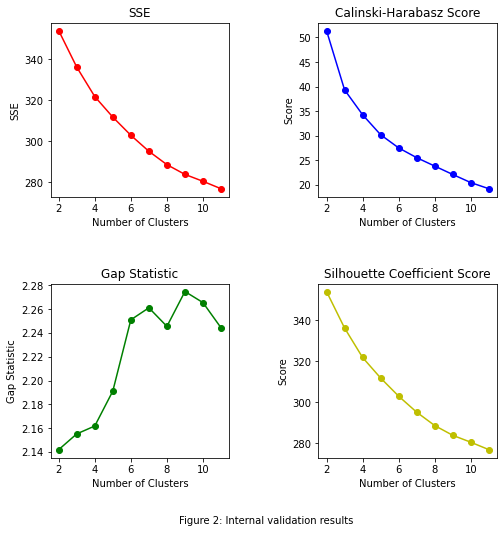

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax[0][0].plot(np.arange(2, 12), cluster_range['inertias'], 'or-')
ax[0][0].set_xlabel('Number of Clusters')
ax[0][0].set_ylabel('SSE')
ax[0][0].set_title('SSE')

ax[0][1].plot(np.arange(2, 12), cluster_range['chs'], 'ob-')
ax[0][1].set_xlabel('Number of Clusters')
ax[0][1].set_ylabel('Score')
ax[0][1].set_title('Calinski-Harabasz Score')

ax[1][0].plot(np.arange(2, 12), cluster_range['gss'], 'og-')
ax[1][0].set_xlabel('Number of Clusters')
ax[1][0].set_ylabel('Gap Statistic')
ax[1][0].set_title('Gap Statistic')

ax[1][1].plot(np.arange(2, 12), cluster_range['inertias'], 'oy-')
ax[1][1].set_xlabel('Number of Clusters')
ax[1][1].set_ylabel('Score')
ax[1][1].set_title('Silhouette Coefficient Score')

txt = 'Figure 2: Internal validation results'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center')
plt.show()

We observed that the gap statistic at $k=7$ and $k=9$ show highest, while for both Calinski-Harabasz and Silhouette scores, the peak is at $k=2$. SSE usually tends to decrease as $k$ increases, as observed in the results shown. While these metrics may suggest choices of $k$ based on quantitative measures, there is still a need to investigate further clusters based on interpretability and visual inspection of the plots as discussed in the following sections.

#### B. Interpretation of Cluster Terms

Our final choice of $k=4$ is supported by the interpretation of the most frequent terms/words for each cluster. Inspecting results for $k$ lower and higher than $k=4$ yielded clusters in which the most frequent words either overlapped or gave little meaning to the cluster results--something likely impacted as well by our sub-optimal stopword generator. However we found that for $4$ clusters, the results can be interpreted as follows:

|Rank|Corporate Tax|Criminal Tax Evasion|VAT-related|Tax Disputes|
|:--|:--|:--|:--|:--|
|1st|income|excise|vat|assessment|
|2nd|credit|product|input|deficiency|
|3rd|withholding|criminal|zerorated|notice|
|4th|withheld|stamp|credit|letter|
|5th|excess|trial|judicial|protest|
|6th|gross|petitioner|quarter|withholding|
|7th|creditable|custom|invoice|income|
|8th|option|exemption|good|collection|
|9th|succeeding|jurisdiction|unutilized|prescription|
|10th|bank|assessment|mandatory|request|

Upon conducting our own research, as well as consulting professioals, we were able identify these clusters as: <br>

> **Corporate Tax Cases** - Most of the words in this cluster involve terms are mostly used in a business setting, such as `withholding`, `income`, and `bank`. As such, it is most likely that this tax relates to corporate and business taxes.<br>
<br>
**Criminal Tax Evasion Cases** - The cluster contains key words such as `criminal` and `trial`. We were informed by professionals are only used in criminal cases. The fact that these words are only present in this cluster is a strong case for its differentiation and segregation from the others.<br>
<br>
**VAT Cases** - The words in this cluster inclused `vat`, `input`, and `invoice`. These are word that are heavily associated with the Value Added Tax. Additionally, VAT is one of the only tax types with the concept of an "input" which is a strong case that this cluster is mostly VAT related.<br>
<br>
**General Tax Disputes Tax Cases** - This cluster is much more general than the others, it does not label any specific form of tax but instead contains words such as `assessment`, `deficiency`, and `notice`. All of these words indicate that the BIR disputes that the tax payer has paid the adequate tax. The fact that this rose all the way to the supreme court indicates that the tax payer vehemently disagrees with the assessment.<br>



#### C. Visualization of Clusters

To further verify the choice of $k=4$, we plotted a decomposed version of our dataset after applying a `sklearn`'s `TruncatedSVD()` with the clustering results as hues. See the figure below.


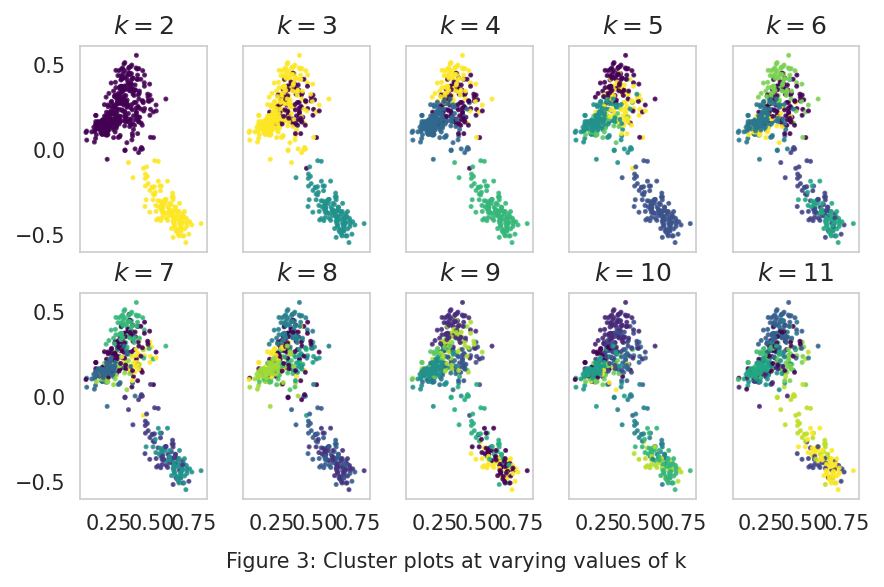

In [28]:
trunc_svd = TruncatedSVD(n_components=2, random_state=1337)
trunc_vals = trunc_svd.fit_transform(vect_df)
case_retriever.plot_clusters(trunc_vals, cluster_range['ys']);
txt = 'Figure 3: Cluster plots at varying values of k'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center');
plt.show()

We observed from the results that in two dimensions, a choice of $k=2$ visibly qualifies the clusters as parsimonious, compact, balanced, and separated. However, a look into the most frequent words within the clusters yield results that were difficult to interpret. Additionally, based on the practitioner's advice, more clusters could possibly capture more specific themes within the corpus of tax cases. Thus, our choice was heavily based on the interpretation of the most frequent words per cluster, as discussed in the previous section.

We then plotted the results of our choice of $k=4$ onto a three-dimensions, taking the three principal components resulting from the bag-of-words decomposition. 


In [31]:
trunc_svd = TruncatedSVD(n_components=3, random_state=1337)
trunc_vals = trunc_svd.fit_transform(vect_df)

In [32]:
kmeans = KMeans(n_clusters=4, random_state=1337)
y_predict = kmeans.fit_predict(vect_df)
cluster_centers = kmeans.cluster_centers_

In [33]:
tax_cases['Clusters'] = y_predict
tax_cases['Centroids'] = tax_cases.Clusters.apply(lambda x: cluster_centers[x])

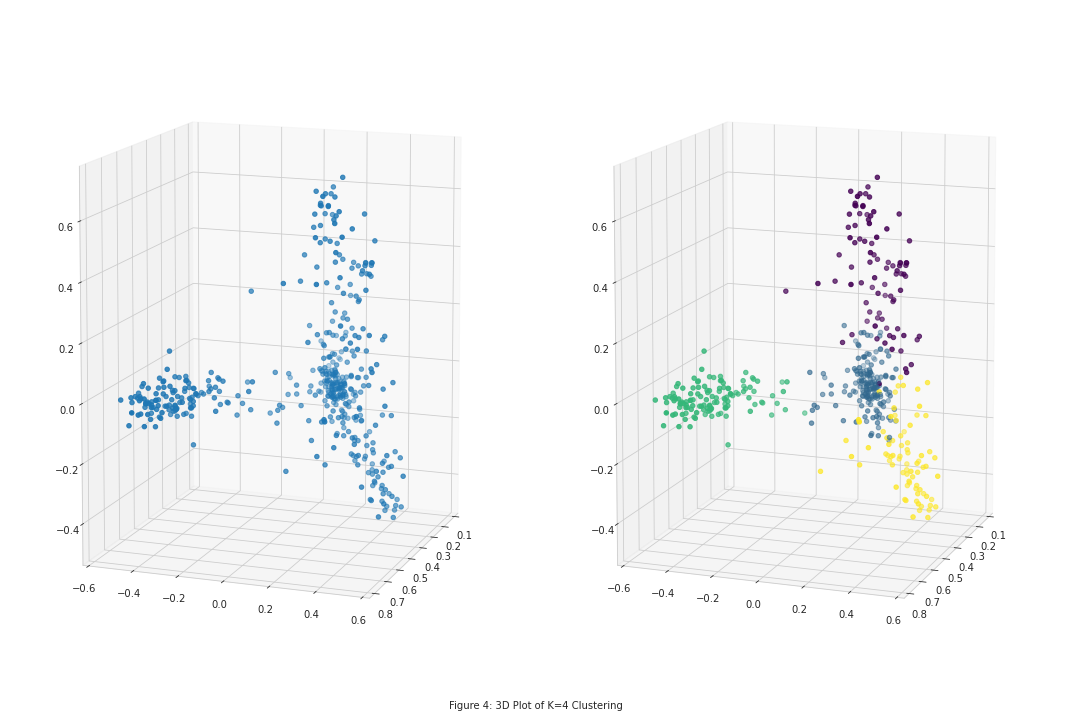

In [34]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121, projection='3d')
# ax1 = Axes3D(fig)
ax1.scatter(trunc_vals[:, 0], 
           trunc_vals[:, 1],
           trunc_vals[:, 2], 
           marker='o', cmap='viridis')
ax1.view_init(10, 20)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(trunc_vals[:, 0], 
           trunc_vals[:, 1],
           trunc_vals[:, 2], 
           c=y_predict, 
           marker='o', cmap='viridis')
ax2.view_init(10, 20)

txt = 'Figure 4: 3D Plot of K=4 Clustering'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center')

plt.tight_layout()
plt.show()

From Figure 3, we can now observe a parsimonious, compact, balanced, and separated clusters in the above projection. This further supports our choice of $k=4$ clusters.

#### D. Case Retrieval System Evaluation

The case retrieval system constructed was evaluated according to the area under the receiving operator characteristic curve (AUC-ROC Curve). The result of the clustering of tax cases into $4$ clusters mention was used as the 'ground truth' to the performance evaluation.

In [23]:
objects = vect_df.copy()
all_labels = tax_cases['Clusters'].values
query_case = tax_cases.iloc[0]
query_doc = query_case.Text
query = vectorizer.vectorize_doc(vect, [query_doc])

In [24]:
# sample calls for closest_euc and compute_auc_euc
# using the first document as the query
from scipy.spatial.distance import euclidean
euc_ = case_retriever.closest_euc(query.toarray(), objects, 
                                  query_case.Clusters, all_labels)
auc_euc_ = case_retriever.compute_auc_euc(query.toarray(), objects, 
                                          query_case.Clusters, euclidean, 
                                          all_labels)

In [25]:
from scipy.spatial.distance import euclidean, cityblock, cosine


def get_auc_mean(dist):
    auc_list = []
    for i in range(objects.shape[0]):
        query_case = tax_cases.iloc[i]
        query_doc = query_case.Text
        query = vectorizer.vectorize_doc(vect, [query_doc])
        auc_list.append(case_retriever.compute_auc_euc(query.toarray(), 
                                                       objects, 
                                                       query_case.Clusters, 
                                                       dist,
                                                       all_labels))
    return np.mean(auc_list)

In [26]:
distance_metrics = [euclidean, cityblock, cosine]
dnames = ["euclidean", "cityblock", "cosine"]
auc_dict = {}
for name, i in tqdm(zip(dnames, distance_metrics)):
    auc_dict.setdefault(name, get_auc_mean(i))

3it [01:25, 28.58s/it]


The AUC-ROC was obtained by calculating the respective precision and recall obtained when each document in the corpus was used as the search query. The AUC-ROC Curve corresponds to the area under the curve when precision was plotted versus recall, where a value of 1.0 indicates a perfect score for this metric. This same procedure was tested for three different distance metrics shown below:

|Distance Metric|AUC||
|:--|:--|---|
|Euclidean (L2)|0.745|
|Cosine similarity|0.745|
|Manhattan (L1)|0.578|

The AUC-ROC of the Euclidean and Cosine similarity metrics proved to be superior than the Manhattan (L1) distance. This justified our choice of using Euclidean norm as a distance metric for our case retriever. 

## IV. Conclusion

We were successful in clustering the tax-related Supreme Court cases into four clusters: `VAT-related`, `Criminal Tax Evasion`, `Corporate Tax`, and `Tax Disputes` clusters. These clusters were a result of qualitative external validation from practitioners as well as visual inspection of KMeans() clustering results for different numbers of clusters, 𝑘. A 3-dimensional representation of the clusters aided in choosing 𝑘=4, which would provide the most balanced, parsimonious, separated, and compact clusters. More importantly, the resulting clusters can easily be interpreted according to the resulting word frequencies.

Furthermore, we found that our idf scoring-based stopwords generator was successful in obtaining stopwords. However, we also found that our stopword generator needs refinement due to the arbitrary nature of selecting an idf score threshold. As a result, we still had to qualitatively adjust the max_df parameter of the `TfidfVectorizer()` to reduce noise from frequently occurring terms.


We were also successful in creating a case retrieval system with a performance of 0.745, according to the AUC-ROC metric used. This AUC-ROC Curve score is dependent on the ground truth used, which, in the case of our study, was the result of `KMeans()` clustering. The effectiveness of our information retrieval system depends on techniques employed in removing noise, representing documents as vectors, and in establishing a reliable ground truth (labels) for the documents in the corpus.



## V. Recommendations

This study provides countless opportunities for improvement to optimize a search engine for Supreme Court cases. Specifically, we recommend that the stopword generator be improved to generate an exhaustive list of corpus specific stopwords, such as the one pursued by <a href="http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf">Lo *et al* (2020)</a>. We also recommend that a careful validation by practitioners and experts be done to improve the integrity and interpretation of clustering results.

In a more elaborate direction, our initial approach can be improved by applying the same procedure to other types of cases available in the Supreme Court library. All these are significant steps in successfully facilitating law research through a reliable search engine for law practitioners, and ultimately, in getting a clearer picture of the Philippine judiciary system.

### References

1. Medvedeva, Vols, and Wieling. 2019. "Using machine learning to predict decisions of the European Court of Human Rights". link.springer. https://link.springer.com/article/10.1007/s10506-019-09255-y.<br>
2. Chibueze 2018. "NLP For Topic Modeling & Summarization Of Legal Documents". towardsdatascience. https://towardsdatascience.com/nlp-for-topic-modeling-summarization-of-legal-documents-8c89393b1534.<br>
3. Marr 2019. "How AI And Machine Learning Are Transforming Law Firms And The Legal Sector". Forbes. https://www.forbes.com/sites/bernardmarr/2018/05/23/how-ai-and-machine-learning-are-transforming-law-firms-and-the-legal-sector/#14ba15e332c3.<br>
4. Virtucio et al 2019. "Predicting Decisions of the Philippine Supreme Court Using Natural Language Processing and Machine Learning. ieeexplore.ieee.org. https://ieeexplore.ieee.org/document/8377844.
<br>
5. Supreme Court E-Library. http://elibrary.judiciary.gov.ph/.
6. Lo, He, and Ounis. 2020. "Automatically building a stopword list for an Information Retrieval System." http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf

In [41]:
# Add cells above this
# This will generate the html report for this notebook
!jupyter nbconvert  "DMW Project Tech Report.ipynb" --to html

[NbConvertApp] Converting notebook DMW Project Tech Report.ipynb to html
[NbConvertApp] Writing 889764 bytes to DMW Project Tech Report.html
